# preprocessing

In [9]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt

#NEURAL NET
from sklearn.model_selection import KFold
from collections import defaultdict

In [2]:
# load data
data_dir = "data/"

college_players_stats = pd.read_csv(f'{data_dir}college_players_stats.csv', index_col=0)
drafted_players = pd.read_csv(f'{data_dir}drafted_players.csv', index_col=0)
not_drafted = pd.read_csv(f'{data_dir}not_drafted.csv', index_col=0)
players_stats = pd.read_csv(f'{data_dir}players_stats.csv', index_col=0)

# add label and normalize relevant values

players_stats['drafted'] = players_stats['name'].isin(drafted_players['name'])
players_stats['drafted'] = players_stats['drafted'].astype(int)


# add label and normalize relevant values

players_stats['drafted'] = players_stats['name'].isin(drafted_players['name'])
players_stats['drafted'] = players_stats['drafted'].astype(int)
players_stats = players_stats.drop(columns=['name'])

# discretize height
def convert_height(height_str):
    feet, inches = map(int, height_str.split('-'))
    return feet + inches / 12  

# Apply the conversion function to the height column
players_stats['height'] = players_stats['height'].apply(convert_height)

# add binary columns for each position label
def str_to_int(maybe_bool):
    if isinstance(maybe_bool, bool):
        return int(maybe_bool) 
    return maybe_bool

def weight_to_int(input):
    if(input == "22l"):
        return 221
    return(int(input)) 
players_stats['weight'] = players_stats['weight'].apply(weight_to_int)

players_stats = pd.get_dummies(players_stats, columns=['position'])
players_stats = players_stats.applymap(str_to_int)

players_stats.info()
non_numeric_columns = players_stats.select_dtypes(exclude=["number"]).columns
print("Non-numeric columns:", non_numeric_columns)

# TODO: add other metrics for training
df = players_stats

df.dropna(inplace=True)
pd.set_option('display.max_columns', None)
df.head()

/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/1988355783.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  players_stats = players_stats.applymap(str_to_int)


<class 'pandas.core.frame.DataFrame'>
Index: 31860 entries, 0 to 31859
Data columns (total 45 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   height                     31860 non-null  float64
 1   weight                     31860 non-null  int64  
 2   games_played               31860 non-null  int64  
 3   games_started              31860 non-null  int64  
 4   min_per                    31573 non-null  float64
 5   field_goal                 31860 non-null  float64
 6   field_attmps               31860 non-null  float64
 7   field_pct                  31127 non-null  float64
 8   two_pointer                31860 non-null  float64
 9   two_pattamps               31860 non-null  float64
 10  two_pct                    30592 non-null  float64
 11  three_ptrs                 31860 non-null  float64
 12  three_pattmp               31860 non-null  float64
 13  three_pct                  31127 non-null  float64


,height,weight,games_played,games_started,min_per,field_goal,field_attmps,field_pct,two_pointer,two_pattamps,two_pct,three_ptrs,three_pattmp,three_pct,free_throws,free_attmps,free_pct,assists,steals,blocks,points,off_reb,def_reb,total_reb,turnovers,drafted,position_Center,position_Center-Forward,position_Forward,position_Forward-Center,position_Forward-Guard,position_Forward-PF,position_Forward-SF,position_Forward-SF-Guard,position_Guard,position_Guard-Forward,position_Guard-PG,position_Guard-SG,position_PForward,position_PForward-F,position_PGuard,position_PGuard-G,position_SForward,position_SForward-F,position_SGuard-G
0,6.416667,215,41,19,13.3,0.9,2.1,0.414,0.9,2.0,0.429,0.0,0.1,0.414,0.7,1.2,0.529,0.1,0.4,0.3,2.4,1.3,1.7,3.0,1.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6.750000,225,115,16,11.2,1.5,2.3,0.619,1.5,2.3,0.619,0.0,0.0,0.619,0.6,0.7,0.788,0.2,0.2,0.8,3.5,0.7,1.6,2.3,0.6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.416667,210,92,29,16.4,1.4,4.0,0.346,0.4,1.2,0.360,0.9,2.8,0.346,0.4,0.6,0.611,0.6,0.4,0.2,4.1,0.6,1.4,2.0,0.8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,6.666667,210,107,55,19.0,3.1,6.5,0.473,3.1,6.5,0.474,0.0,0.0,0.473,1.8,2.8,0.641,0.4,0.5,0.7,7.9,2.5,3.2,5.7,1.2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,6.750000,322,86,72,24.5,4.3,7.8,0.544,4.3,7.8,0.544,0.0,0.0,0.544,2.0,4.1,0.482,0.3,0.6,0.6,10.5,3.1,4.3,7.3,1.5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# models

In [3]:
from sklearn.model_selection import train_test_split
from util.analyze import explain

seed = 42
epochs = 250
lr = 0.01
batch_size = 32

# get data
x = df.drop(columns=['drafted']).values
y = df['drafted'].values


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

# downsampling
#separate drafted and non-drafted 
df_drafted = df[df['drafted'] == 1]
df_non_drafted = df[df['drafted'] == 0]


# Drop 3000 random samples from non-drafted
df_non_drafted_sampled = df_non_drafted.sample(len(df_non_drafted) - 20000, random_state=seed)

df_downsampled = pd.concat([df_drafted, df_non_drafted_sampled])
x = df_downsampled.drop(columns=['drafted']).values
y = df_downsampled['drafted'].values

xd_train, xd_test, yd_train, yd_test = train_test_split(x, y, test_size=0.2, random_state=seed)



count = 0
count_tot = 0
for y1,y2 in zip(y_train, y_test):
    if(y1 == 1):
        count+=1
    if(y2 == 1):
        count+=1
    count_tot +=1

print("Count drafted:")
print(count)
print("Count not drafted:")
print(count_tot)

np.unique(y_test, return_counts=True)

count = 0
count_tot = 0
for y1,y2 in zip(yd_train, yd_test):
    if(y1 == 1):
        count+=1
    if(y2 == 1):
        count+=1
    count_tot +=1

print("Count downsample drafted:")
print(count)
print("Count downsample not drafted:")
print(count_tot)

np.unique(y_test, return_counts=True)

Count drafted:
408
Count not drafted:
5723
Count downsample drafted:
418
Count downsample not drafted:
1723


(array([0, 1]), array([5516,  207]))

In [10]:
#all data

In [26]:
# mlp class
class MLP(torch.nn.Module):
    def __init__(self, hidden=16, layers=1):
        super(MLP, self).__init__()
        # self.fc1 = torch.nn.Linear(44, hidden)
        # self.relu = torch.nn.ReLU()
        # self.fc2 = torch.nn.Linear(hidden, 1)
        # self.sigmoid = torch.nn.Sigmoid()

        self.layers = layers

        setattr(self, f'fc1', torch.nn.Linear(44, hidden))
        self.relu = torch.nn.ReLU()

        for layers in range(2, layers+1):
            setattr(self, f'fc{layers}', torch.nn.Linear(hidden, hidden))

        self.output = torch.nn.Linear(hidden, 1)
        self.sigmoid = torch.nn.Sigmoid()


    
    def forward(self, x):
        # x = self.fc1(x)
        # x = self.relu(x)
        # x = self.fc2(x)
        # x = self.sigmoid(x)

        for i in range(1, self.layers+1):
            x = getattr(self, f'fc{i}')(x)
            x = self.relu(x)

        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# mlp
import tqdm


dataset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1))

model = MLP()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for i in tqdm.trange(epochs):
    dl = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    
    for x, y in dl:
        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        optimizer.step()

res = model(torch.tensor(x_test, dtype=torch.float32))

# get loss
loss = criterion(res, torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1))

# get acc
predictions = [1 if x>0.5 else 0 for x in res]
acc = 1- abs(predictions - y_test).sum()/len(predictions)
print(acc)
print(sum(predictions))
print(len(predictions))

results = explain(predictions, y_test, average='macro')

  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/3824919596.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [01:19<00:00,  3.15it/s]

0.9634806919447843
20
5723
Precision:  0.5207420310874294
Recall:  0.7076407154129406
F1:  0.5303330214280133
Accuracy:  0.9634806919447843
Distribution (array([0, 1]), array([5516,  207]))


# grid search

  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:21<00:00, 11.41it/s]


0.897852582704585
147
1723
Precision:  0.6945488721804511
Recall:  0.759116336890086
F1:  0.7201476559616095
Accuracy:  0.897852582704585
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:25<00:00,  9.76it/s]


0.901915264074289
152
1723
Precision:  0.7096561446720249
Recall:  0.7709115045730175
F1:  0.7346343997338936
Accuracy:  0.901915264074289
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:30<00:00,  8.26it/s]


0.8943702843876958
69
1723
Precision:  0.6029427015815401
Recall:  0.778323957730929
F1:  0.6367707290855851
Accuracy:  0.8943702843876958
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:22<00:00, 11.02it/s]


0.9001741149158444
123
1723
Precision:  0.6745235934664247
Recall:  0.7736331300813009
F1:  0.7086322164543023
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:25<00:00,  9.90it/s]


0.9001741149158444
169
1723
Precision:  0.7236080502981592
Recall:  0.7627177050253973
F1:  0.7408406265522138
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:29<00:00,  8.43it/s]


0.9001741149158444
77
1723
Precision:  0.6254391366346902
Recall:  0.8053881112811854
F1:  0.6656935294648497
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:27<00:00,  8.93it/s]


0.8972721996517702
146
1723
Precision:  0.692085817993259
Recall:  0.7574247965184457
F1:  0.7178422967785629
Accuracy:  0.8972721996517702
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:31<00:00,  7.92it/s]


0.8903076030179918
44
1723
Precision:  0.5664943609022557
Recall:  0.7777288970707672
F1:  0.5878684254821535
Accuracy:  0.8903076030179918
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:47<00:00,  5.27it/s]


0.8821822402785838
0
1723
Precision:  0.5
Recall:  0.4410911201392919
F1:  0.4687018193031144
Accuracy:  0.8821822402785838
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:19<00:00, 12.70it/s]


0.9036564132327336
123
1723
Precision:  0.6828995981332642
Recall:  0.7867657520325203
F1:  0.7187962089035709
Accuracy:  0.9036564132327336
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:23<00:00, 10.45it/s]


0.9036564132327336
153
1723
Precision:  0.7149112004148301
Recall:  0.7760626118812706
F1:  0.7399930911603214
Accuracy:  0.9036564132327336
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:28<00:00,  8.79it/s]


0.9013348810214742
131
1723
Precision:  0.6858520222971222
Recall:  0.7749745866738271
F1:  0.7181953573572649
Accuracy:  0.9013348810214742
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:19<00:00, 12.70it/s]


0.9013348810214742
111
1723
Precision:  0.6645109541094114
Recall:  0.7836915699818926
F1:  0.7021601548836339
Accuracy:  0.9013348810214742
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:24<00:00, 10.39it/s]


0.9001741149158444
127
1723
Precision:  0.6787918071039668
Recall:  0.7721765042527579
F1:  0.7117944528727584
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:29<00:00,  8.62it/s]


0.9001741149158444
137
1723
Precision:  0.6894623411978221
Recall:  0.7690535801400944
F1:  0.71937047839097
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:28<00:00,  8.71it/s]


0.9001741149158444
81
1723
Precision:  0.6297073502722323
Recall:  0.800916527571014
F1:  0.6699851226269699
Accuracy:  0.9001741149158444
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:35<00:00,  6.98it/s]


0.8926291352292512
138
1723
Precision:  0.672381384495722
Recall:  0.7431765189960224
F1:  0.6989483427071085
Accuracy:  0.8926291352292514
Distribution (array([0, 1]), array([1520,  203]))


  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_12944/4204739308.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:40<00:00,  6.21it/s]


0.893789901334881
140
1723
Precision:  0.6773074928701063
Recall:  0.746864001443913
F1:  0.7037485589512265
Accuracy:  0.893789901334881
Distribution (array([0, 1]), array([1520,  203]))
           lr=0.01, hidden=16, layers=1  lr=0.01, hidden=16, layers=2  \
precision                      0.694549                      0.709656   
recall                         0.759116                      0.770912   
f1                             0.720148                      0.734634   
accuracy                       0.897853                      0.901915   

           lr=0.01, hidden=16, layers=3  lr=0.01, hidden=32, layers=1  \
precision                      0.602943                      0.674524   
recall                         0.778324                      0.773633   
f1                             0.636771                      0.708632   
accuracy                       0.894370                      0.900174   

           lr=0.01, hidden=32, layers=2  lr=0.01, hidden=32, layers=3  \
precisi

<Axes: >

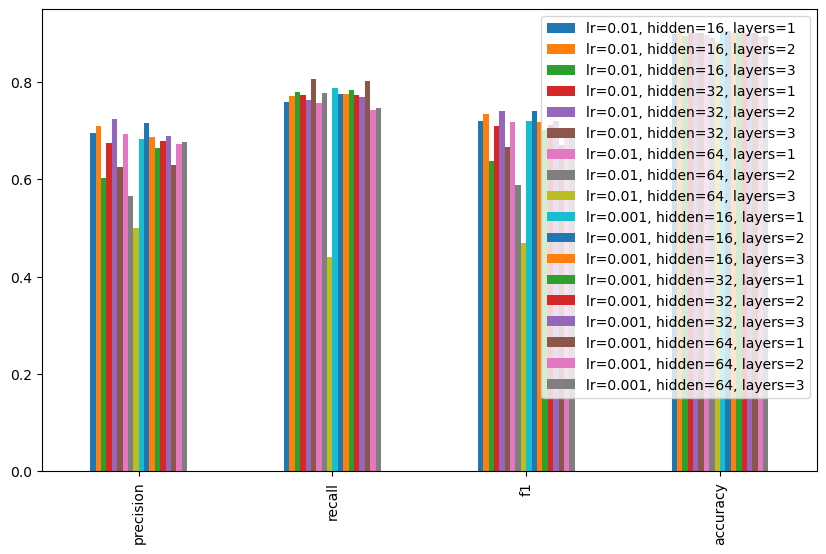

In [30]:
dataset = torch.utils.data.TensorDataset(torch.tensor(xd_train, dtype=torch.float32), torch.tensor(yd_train, dtype=torch.float32).reshape(-1, 1))

my_results = defaultdict(list)

for lr in [0.01, 0.001]:
    for hidden in [16, 32, 64]:
        for layers in [1, 2, 3]:
            model = MLP(hidden=hidden, layers=layers)
            criterion = torch.nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            for i in tqdm.trange(epochs):
                dl = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

                for x, y in dl:
                    optimizer.zero_grad()
                    output = model(x)

                    loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
                    loss.backward()
                    optimizer.step()

            res = model(torch.tensor(xd_test, dtype=torch.float32))

            # get loss
            loss = criterion(res, torch.tensor(yd_test, dtype=torch.float32).reshape(-1, 1))

            # get acc
            predictions = [1 if x>0.5 else 0 for x in res]
            acc = 1- abs(predictions - yd_test).sum()/len(predictions)
            print(acc)
            print(sum(predictions))
            print(len(predictions))

            results = explain(predictions, yd_test, average='macro')
            my_results[f"lr={lr}, hidden={hidden}, layers={layers}"] = results

# plot results
print(pd.DataFrame(my_results).head())
pd.DataFrame(my_results).plot(kind='bar', figsize=(10, 6))


In [ ]:
pd.DataFrame(my_results).head()

,"lr=0.01, hidden=16, layers=1","lr=0.01, hidden=16, layers=2","lr=0.01, hidden=16, layers=3","lr=0.01, hidden=32, layers=1","lr=0.01, hidden=32, layers=2","lr=0.01, hidden=32, layers=3","lr=0.01, hidden=64, layers=1","lr=0.01, hidden=64, layers=2","lr=0.01, hidden=64, layers=3","lr=0.001, hidden=16, layers=1","lr=0.001, hidden=16, layers=2","lr=0.001, hidden=16, layers=3","lr=0.001, hidden=32, layers=1","lr=0.001, hidden=32, layers=2","lr=0.001, hidden=32, layers=3","lr=0.001, hidden=64, layers=1","lr=0.001, hidden=64, layers=2","lr=0.001, hidden=64, layers=3"
precision,0.694549,0.709656,0.602943,0.674524,0.723608,0.625439,0.692086,0.566494,0.500000,0.682900,0.714911,0.685852,0.664511,0.678792,0.689462,0.629707,0.672381,0.677307
recall,0.759116,0.770912,0.778324,0.773633,0.762718,0.805388,0.757425,0.777729,0.441091,0.786766,0.776063,0.774975,0.783692,0.772177,0.769054,0.800917,0.743177,0.746864
f1,0.720148,0.734634,0.636771,0.708632,0.740841,0.665694,0.717842,0.587868,0.468702,0.718796,0.739993,0.718195,0.702160,0.711794,0.719370,0.669985,0.698948,0.703749
accuracy,0.897853,0.901915,0.894370,0.900174,0.900174,0.900174,0.897272,0.890308,0.882182,0.903656,0.903656,0.901335,0.901335,0.900174,0.900174,0.900174,0.892629,0.893790


<Axes: >

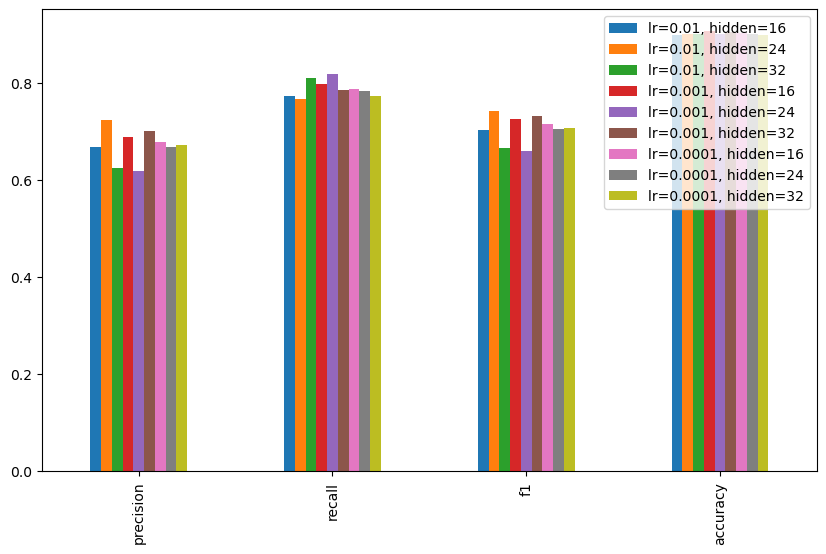

In [28]:
pd.DataFrame(my_results).plot(kind='bar', figsize=(10, 6))

In [13]:
#DOWNSAMPLED 

In [ ]:
model = MLP()
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
for i in tqdm.trange(epochs):
    dl = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    
    for x, y in dl:
        optimizer.zero_grad()
        output = model(x)

        loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
        loss.backward()
        optimizer.step()

res = model(torch.tensor(xd_test, dtype=torch.float32))

# get loss
loss = criterion(res, torch.tensor(yd_test, dtype=torch.float32).reshape(-1, 1))
loss

# get acc
predictions = [1 if x>0.5 else 0 for x in res]
acc = 1- abs(predictions - yd_test).sum()/len(predictions)
print(acc)
print(sum(predictions))
print(len(predictions))

results = explain(predictions, yd_test, average='macro')

  0%|          | 0/250 [00:00<?, ?it/s]/var/folders/30/c46f3dw51w749hbqzgst91r40000gn/T/ipykernel_27794/138103254.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(output, torch.tensor(y, dtype=torch.float32).reshape(-1, 1))
100%|██████████| 250/250 [00:31<00:00,  8.06it/s]

0.8961114335461404
218
1723
Precision:  0.7661216619134043
Recall:  0.750280410862873
F1:  0.7578241495062916
Accuracy:  0.8961114335461404
Distribution (array([0, 1]), array([1520,  203]))


In [ ]:
# K FOLD EVALUATION ON DOWNSAMPLED

In [8]:

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=10)

fold_results = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(xd_train)):
    x_t, y_t = xd_train[train_idx], yd_train[train_idx]
    x_v, y_v = xd_train[test_idx], yd_train[test_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(x_t, dtype=torch.float32),
        torch.tensor(y_t, dtype=torch.float32).reshape(-1, 1)
    )
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = MLP()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    
    val_outputs = model(torch.tensor(x_v, dtype=torch.float32))
    predictions = [1 if x>0.5 else 0 for x in val_outputs]

    results = explain(predictions, y_v, average='binary')
    fold_results.append(results)

#avg explain results across all folds

print("AVERAGE RESULTS")
print("\n\n")

#make a new dict with the avgs
countdict = defaultdict(lambda: {'sum': 0, 'count': 0})
for d in fold_results:
    for key, value in d.items():
        countdict[key]['sum'] += value
        countdict[key]['count'] += 1
averaged_dict = {key: acc['sum'] / acc['count'] for key, acc in countdict.items()}

print(averaged_dict)

pd.DataFrame(results).plot(kind='bar', figsize=(10, 6))

Precision:  0.39325842696629215
Recall:  0.6363636363636364
F1:  0.4861111111111111
Accuracy:  0.892675852066715
Distribution (array([0, 1]), array([1201,  178]))
Precision:  0.40145985401459855
Recall:  0.6790123456790124
F1:  0.5045871559633027
Accuracy:  0.9216255442670537
Distribution (array([0, 1]), array([1241,  137]))
Precision:  0.44375
Recall:  0.6396396396396397
F1:  0.5239852398523985
Accuracy:  0.9063860667634253
Distribution (array([0, 1]), array([1218,  160]))
Precision:  0.4484848484848485
Recall:  0.5873015873015873
F1:  0.5085910652920962
Accuracy:  0.8962264150943396
Distribution (array([0, 1]), array([1213,  165]))
Precision:  0.2875
Recall:  0.5168539325842697
F1:  0.36947791164658633
Accuracy:  0.886066763425254
Distribution (array([0, 1]), array([1218,  160]))
AVERAGE RESULTS





NameError: name 'defaultdict' is not defined

In [ ]:
#K FOLD CROSS WITHOUT DOWNSAMPLING

In [ ]:

k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=20)

fold_results = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(x_train)):
    x_t, y_t = x_train[train_idx], y_train[train_idx]
    x_v, y_v = x_train[test_idx], y_train[test_idx]

    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(x_t, dtype=torch.float32),
        torch.tensor(y_t, dtype=torch.float32).reshape(-1, 1)
    )
    train_dl = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

    model = MLP()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for x_batch, y_batch in train_dl:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

    
    val_outputs = model(torch.tensor(x_v, dtype=torch.float32))
    predictions = [1 if x>0.5 else 0 for x in val_outputs]

    results = explain(predictions, y_v, average='macro')
    fold_results.append(results)

#avg explain results across all folds

print("AVERAGE RESULTS")
print("\n\n")

#make a new dict with the avgs
countdict = defaultdict(lambda: {'sum': 0, 'count': 0})
for d in fold_results:
    for key, value in d.items():
        countdict[key]['sum'] += value
        countdict[key]['count'] += 1
averaged_dict = {key: acc['sum'] / acc['count'] for key, acc in countdict.items()}

print(averaged_dict)

pd.DataFrame(results).plot(kind='bar', figsize=(10, 6))

Precision:  0.5
Recall:  0.4820921598602315
F1:  0.4908828107627307
Accuracy:  0.964184319720463
Distribution (array([0, 1]), array([4415,  164]))
Precision:  0.5
Recall:  0.48252512013979904
F1:  0.49110715873721655
Accuracy:  0.9650502402795981
Distribution (array([0, 1]), array([4418,  160]))
Precision:  0.5
Recall:  0.4841633901266929
F1:  0.4919542781045389
Accuracy:  0.9683267802533858
Distribution (array([0, 1]), array([4433,  145]))
Precision:  0.5
Recall:  0.48197903014416776
F1:  0.49082415749082414
Accuracy:  0.9639580602883355
Distribution (array([0, 1]), array([4413,  165]))
Precision:  0.5
Recall:  0.48230668414154654
F1:  0.49099399599733157
Accuracy:  0.9646133682830931
Distribution (array([0, 1]), array([4416,  162]))
AVERAGE RESULTS



{'precision': 0.5, 'recall': 0.4826132768824875, 'f1': 0.49115248021852836, 'accuracy': 0.965226553764975}
